# Style Transfer with Deep Neural Networks


In this notebook, we’ll implement and go through a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.


An example is shown below, where the content image is of a dog, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the dog but is stylized with the waves, blue and beige colors, and block print textures of the style image. Target image below is obtained by running the code provided in this notebook.

<img src='images/target-image.PNG' width=60% />

#### Introduction

The paper starts off by discussing that a limiting factor for previous approaches has been the lack of image representations that explicitly represent semantic information and, thus, allow to separate image content from style.
The authors are introducing A Neural Algorithm of Artistic Style that can **separate and recombine the image content and style of natural images**.

The authors are indicating that their results demonstrate the Convolutional Neural Network's potential for high level
image synthesis and manipulation. They are defining two key characteristic of the image style transfer algorithm by explaining the ability and the prerequisity of the algorithm. Following are excerpts from the paper:

- A style transfer algorithm should be able to extract the semantic image content from the target image (e.g. the objects and the general scenery) and then inform a texture transfer procedure to render the semantic content of the target image in the style of the source image.

- A fundamental prerequisite is to find image representations that independently model variations in the semantic image content and the style in which it is presented.

This is being achieved through getting the style representation and the content representation by feeding the style image and the content image to the CNN respectively. 

In this work, it is shown how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the `content` and the `style` of natural images. For this purpose, a state-of-art CNN, VGG19, is used to extract both content and the style of the image and therefore, the problem is returning into an optimisation problem within a single neural network.

#### Image Representations

 > **Content Representation**
 
A given input image $x$ is encoded in each layer of the Convolutional Neural Network by the filter responses to that image. We can visualise the information at different processing stages in the CNN by reconstructing the input
image from only knowing the network’s responses in a particular layer.

 > **Style Representation**

The style representation computes correlations between the different features in different layers of the CNN. We reconstruct the style of the input image from a style representation built on different subsets of CNN layers. This results in images that match the style of a given image on an increasing scale while discarding information of the global arrangement of the scene. 

- A strong emphasis on style will result in images that match the appearance of the artwork, effectively giving a texturised version of it

### Style Transfer Algorithm

1. The style image $a$ is passed through the network and its style representation A on all layers included are computed and stored
2. The content image $p$ is passed through the network and the content representation P in one layer is stored
3. Then a random white noise image $x$ is passed through the network and its style features G and content features F are computed
4. On each layer included in the style representation, the element-wise mean squared difference between G  and A is computed to give the style loss L_style 
5. Also the mean squared difference between F and P is computed to give the content loss L_content
6. The total loss L_total is then a linear combination between the content and the style loss.
7. Its derivative with respect to the pixel values can be computed using error back-propagation. 
8. This gradient is used to iteratively update the image $x$ until it simultaneously matches the style features of the style image $a$ and the content features of the content image $p$

---
### Convolutional Neural Network

The results presented in this paper are generated on the basis of the VGG network. Style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. conv1_1 is the first convolutional layer that an image is passed through, in the first stack. conv2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv5_4.

<img src='images/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to obtain a new, _target_ image which should contain our desired content and style components:
 > objects and their arrangement are similar to that of the **content image**        \
 > style, colors, and textures are similar to that of the **style image**

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. 

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
# get the "features" portion of VGG19 (we do not need the "classifier" portion as stated in the paper)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)
    

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

Below is a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, we are loading in images by file name and forcing the style image to be the same size as the content image.

In [5]:
# load in content and style image
content = load_image('images/forest.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/Van-Gogh-Starry-Night.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

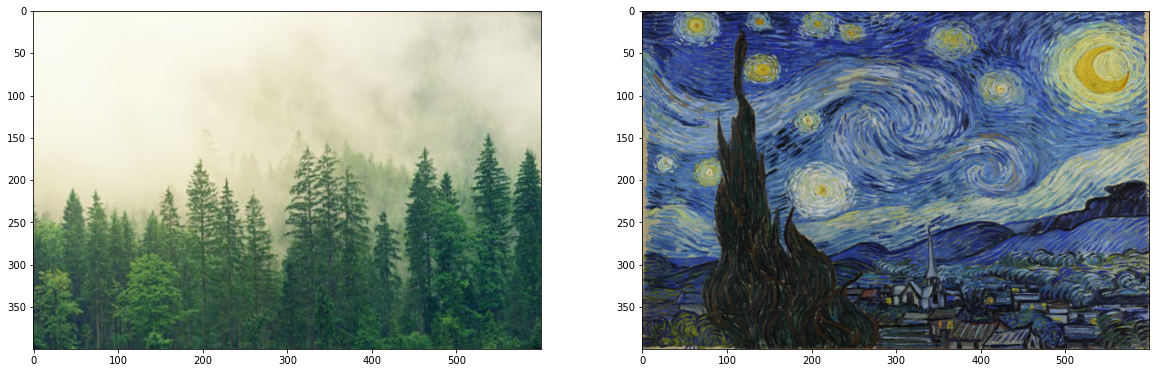

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

## Content and Style Features

We will implement the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [8]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Mapping layer names of PyTorch's VGGNet to names from the paper
    
    # From paper:
    # synthesised by matching the content representation
    # on layer conv4_2 and the style representation on layers
    # conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1
    # w = 1/5 in those layers, w = 0 in all other layers
    # The ratio α/β was either 1 × 10−3, 8 × 10−4, 5 × 10−3, 5 × 10−4

    if layers is None:
        layers = {
                  '0': 'style_layer_1',
                  '5': 'style_layer_2',
                  '10': 'style_layer_3',
                  '19': 'style_layer_4',
                  '21': 'content_layer',    # content representation
                  '28': 'style_layer_5',
                 }
        
    # The style representation computes correlations 
    # between the different features in different layers of the CNN
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

In [9]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    ## calculate the gram matrix
    # batch_size, depth, height, width = tensor.size()
    # vectorize feature maps and multiply with transpose
    gram = torch.flatten(tensor, start_dim=2)
    gram = torch.bmm(gram, torch.transpose(gram, 1, 2))
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; we will put all these pieces together. We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [10]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# init a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ our final image is. It's recommended that to leave the content_weight = 1 and set the style_weight to achieve the ratio we want.

In [11]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'style_layer_1': 1.,
                 'style_layer_2': 0.8,
                 'style_layer_3': 0.5,
                 'style_layer_4': 0.3,
                 'style_layer_5': 0.1}


content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

We are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is up to us to set. **It is recommended using at least 2000 steps for good results.** 

Inside the iteration loop, we'll calculate the content and style losses and update the target image, accordingly.

#### Content Loss

We will calculate the content loss based on the content representations. Therefore, we are interested in the outputs of the `conv4_2` layer. The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only we have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> We'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> We will normalize this value in each layer by the size of the layer.

#### Total Loss

Finally, we'll construct the total loss by adding up the style and content losses and weighting them with our specified alpha and beta!

Total loss:  22738722.0


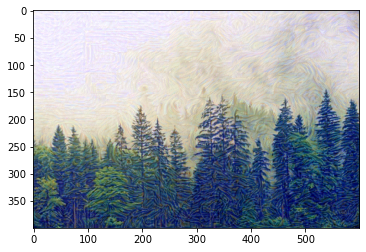

Total loss:  12621741.0


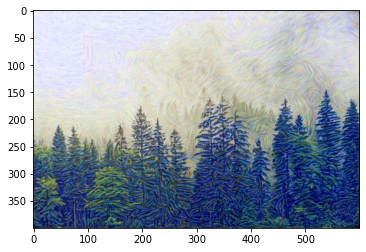

Total loss:  9118284.0


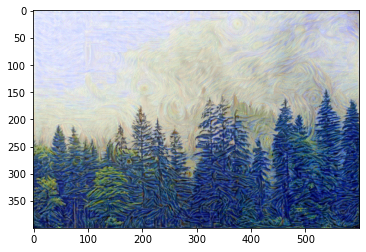

Total loss:  6695431.0


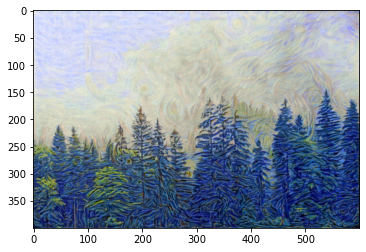

Total loss:  4913887.0


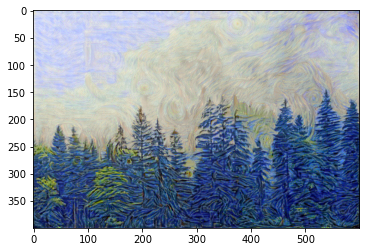

Total loss:  3608568.0


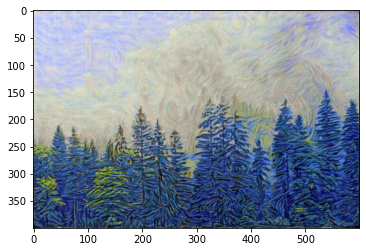

Total loss:  2650194.75


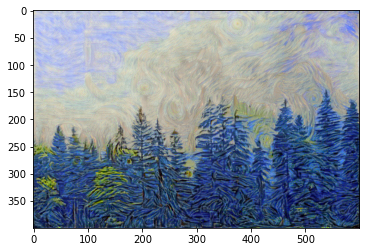

Total loss:  1937463.125


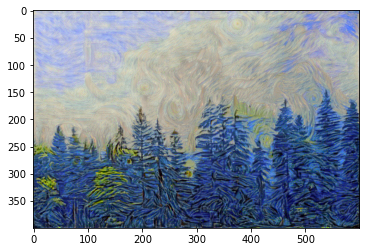

Total loss:  1405161.75


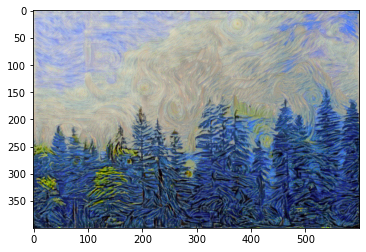

Total loss:  1013272.8125


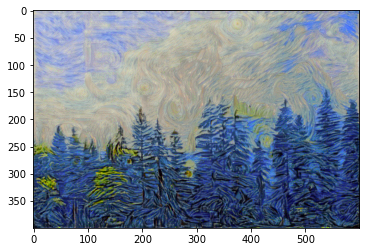

In [12]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # iterations to update the image (5000)

for i in range(1, steps+1):
    
    ## Get the features from the  
    target_features = get_features(target, vgg)
    # content representation of the target image
    # target_features['conv4_2']
    content_loss = torch.mean((target_features['content_layer'] - content_features['content_layer']) ** 2)
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # calculate the gram matrices for each layer of our style representation for target image
        target_gram = gram_matrix(target_feature)
        
        ## get the "style" style representation
        style_gram = style_grams[layer]
        ## Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        
        # add to the style loss
        # normalize by the number of values in that layer 
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update our target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

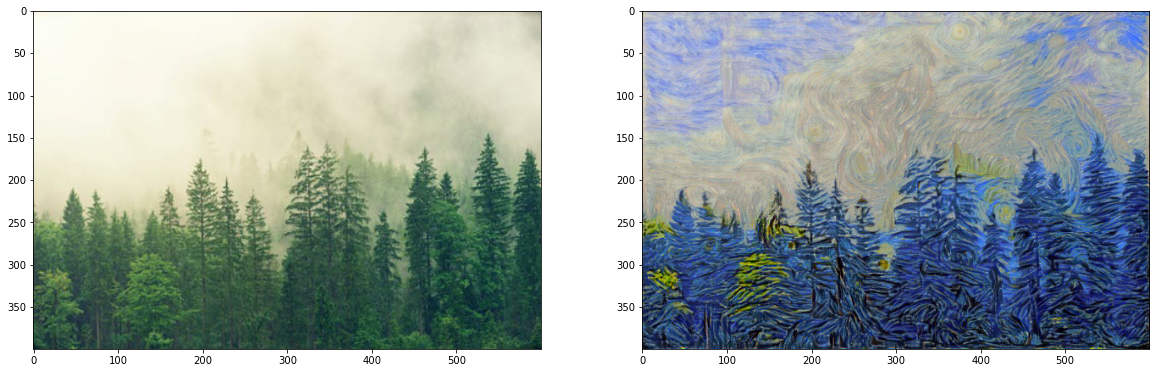

In [13]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

This notebook is adapted from Udacity Deep Learning program